## **<ins><center>FAI TUTORIAL</center></ins>**

This notebook provides a basic overview and information on how to use the CASSIOPE FAI level 1 files to create custom images, videos and projection of images onto a map.

### <ins>Table of Contents</ins>

* [About FAI](#about-fai)
* [Prerequisites](#prerequisites)
* [How the FAI files are stored](#how-the-fai-files-are-stored)
* [Tutorials](#tutorials)
    1. [Reading FAI level 1 Zip files](#reading-fai-level-1-zip-files)
    2. [Reading the attributes of H5 file](#reading-the-attributes-of-h5-files)
    3. [Writing a check for Attitude Determination Mode](#writing-a-check-for-attitude-determination-mode)
    4. [Creating an Image from H5 file](#creating-an-image-from-h5-file)
    5. [Applying Color Scaling to FAI Images](#applying-color-scaling-to-fai-images)
    6. [Converting FAI images to an basic video](#converting-fai-images-into-an-basic-video)
    7. [Projecting the images on a map](#projecting-the-images-on-a-map)

<a id="about-fai"></a>

### <ins>About FAI</ins> 

&emsp; The Fast Auroral Imager (FAI) is part of the Enhanced Polar Outflow Probe (e-POP) instrument suite on the Canadian CASSIOPE small satellite. FAI consists of two CCD cameras: one to measure the 630 nm emission of atomic oxygen in aurora and enhanced night airglow; and the other to observe the prompt auroral emissions in the 650 to 1100 nm range. The cameras have a common 26 degree field-of-view to provide nighttime images of about 650 km diameter from apogee at 1500 km. The near infrared camera provides 0.1 s exposures at 1 Hz with a spatial resolution of a few km when the camera is pointing in the nadir direction, making it suitable for studies of dynamic auroral phenomena. The 630-nm camera provided one image of 0.5 s exposure every 30 seconds, and was retired in 2016 due to significant dark current contamination. The following is the instrument parameter data table from the instrument paper in Space Science Reviews:

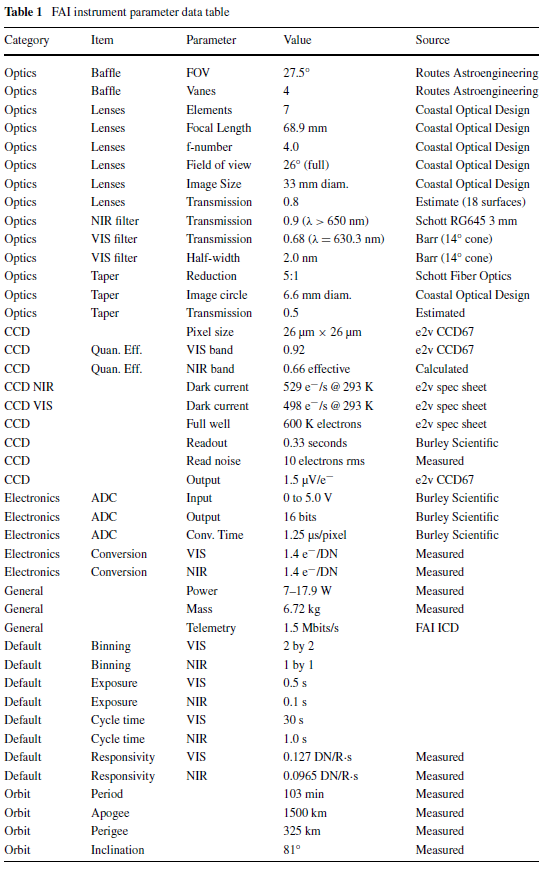

In [1]:
from IPython.display import display, Image
display(Image(filename="fai_instrument.png", height=504, width=463))

You can find the open-access paper __[here](https://link.springer.com/article/10.1007/s11214-014-0107-x)__.

<a id="prerequisites"></a>

### <ins>Prerequisites</ins> 

1. This tutorial assumes you have some basic understanding of Python and its terminology. The python version used here is 3.10.4

2. You will be required to install the following libraries in your python environment:
    *  __[h5py](https://docs.h5py.org/en/stable/build.html)__
    *  __[pandas](https://pandas.pydata.org/docs/getting_started/install.html)__
    *  __[matplotlib](https://matplotlib.org/stable/users/installing/index.html)__
    *  __[numpy](https://numpy.org/install/)__
    *  __[ffmpeg](https://ffmpeg.org/about.html)__
    *  __[cartopy](https://scitools.org.uk/cartopy/docs/latest/installing.html)__

<a id="how-the-fai-files-are-stored"></a>

<a id="how-the-fai-files-are-stored"></a>
#### <ins>How the FAI files are stored</ins>

&emsp; For a single pass of FAI all the files are stored in a *zip* format. The *zip* format contains all the *H5* files from that pass. Each *H5* file contains three datasets, namely *FAI Image*: this contains the raw values of the image pixels, *Pixel Latitudes*: This contains the latitude information of each pixel from the image and *Pixel Longitudes*: This contains the longitude information of each pixel from the image. Pixels that are pointed off of the Earth's surface are set to *NaNs*. Along with these three datasets the h5 files also contain information about the attributes of the spacecraft, such as the FAI CCD temperature, S/C parameters such as latitude, longitude, altitude, yaw, pitch, roll, etc.

<ins>About the attitude quality of the pass</ins>: The attributes section of the h5 files contain one important property called *Attitude Determination Mode*, this property describes the calibration quality of the pass and has 5 integer values corresponding to the following description:

&emsp; 0: No Solution <br>
&emsp; 1: Coarse Sun Sensors <br>
&emsp; 2: Coarsely-Splined Star Sensors <br>
&emsp; 3: Moderately-Splined Star Sensors <br>
&emsp; 4: Finely-Splined Star Sensors <br> 

&emsp; Our recommendation is to work with passes which have a *Attitude Determination Mode* of 4, otherwise the readings from other attributes could be problematic. With passes having a *Attitude Determination Quality* of anything other than 4, the datasets for *Pixel Latitudes* and *Pixel Longitudes* might not be present in the h5 file. Follow along to learn how to write a check for attitude determination.  

<a id="tutorials"></a>

## **<ins><center>Tutorials</center></ins>**

<a id="reading-fai-level-1-zip-files"></a>

### <ins>Reading FAI Level 1 Zip Files</ins> 

The following blocks of codes will teach you how to read an FAI level 1 zip file and convert the same into an image with color scaling applied.

The level 1 files can be downloaded either from __[e-POP data website](https://epop-data.phys.ucalgary.ca/)__ (if you want to download individual zip files) or __[eDEx (e-POP Data Explorer)](https://edex.phys.ucalgary.ca/)__ (if you require multiple zip files based on some date range or conditional constraints). 

For this illustration, we will use the h5 file from 1<sup>st</sup> February 2017 created from 08:10:42 to 08:15:29 UTC. If you plan on using the same file, you may download it from __[here](https://epop-data.phys.ucalgary.ca/2017/02/01/FAI/FAI_lv1_h5_20170201_081042_081529_6.0.0.zip)__, although the process would be the same for any other zip file containing h5 files. 

Now, with the zip file on your local machine you can use the following code to extract all the h5 files into your current working directory with name *temp*.


In [19]:
import zipfile          #to extract zipfiles
import os               #create new directory to store extracted files


"""
name of the zip file 
if your zip file is stored somewhere else other than your current working directory,
then copy paste the entire path to the zip file with the name and .zip extension"""
filename = "FAI_lv1_h5_20170201_081042_081529_6.0.0.zip"  


"""
name of the folder where the files would be stored
if you would like the extracted folder to be somewhere other than your
current working directory, then paste the entire address to the 
folder_name object below"""
folder_name = "temp"


"""NOTE -> if the folder with the same name already exists and you 
    try executing the following you would end up having an error
    so, you would either need to delete the pre existing folder, 
    change the name of the folder or comment the following line"""
#if the folder does not exist the following line would create a folder 
#with folder_name as the name
os.mkdir(folder_name)


"""the following two lines of code would first open the Zipfile 
as file in read mode ("r") and the file.extractall function 
would extract the contents of the file to the specified folder
if you would like to extract all the files to the current working directory 
then change file.extractall(path=folder_name) to file.extractall()"""
with zipfile.ZipFile(filename, "r") as file:
    file.extractall(path=folder_name)

&emsp; The goal for the above code is to extract one zipfile into a folder with the same name. We first import the two necessary modules os and zipfile. Then we mention the name of the file along with the name of the folder which would contain the extracted files from the zipfiles. We use the same name for the folder but you can change the name of the folder to whatever you like. Then with the builtin ZipFile function of the zipfile module we extract all the h5 files into the created folder. 

<a id="reading-the-attributes-of-h5-files"></a>

### <ins>Reading the attributes of H5 files</ins> 

With the *h5py* module installed, we are ready to read the h5 files we extracted. 

H5 files in general acts like a python dictionary, you can read more about the HDF5 file format __[here](https://docs.h5py.org/en/stable/index.html)__. FAI h5 files contain the following:

* "Fai Image" contains the value in Rayleighs of each pixel in the image. Size of (280x256), (140x128), or (70x64), depending on the 'Camera Mode' setting
* "Pixel Latitudes" contains the latitude in degrees of each pixel corner of the FaiImage. It has one more column and row than the FaiImage size.
* "Pixel Longitudes" is the same as "Pixel Latitudes", but contains the longitude of each pixel corner instead of latitude.
* attributes is a dataframe of satellite data at the time the image was taken. It gives context for the image. To access values whose titles contain (°), use '\N{DEGREE SIGN}' or copy and paste ' ° '.

In the following code, we would first work with one of the h5 files that we extracted (*FAI_lv1_NIR_20170201_081042_081042_6.0.0.h5*). Further on in the tutorial there is an example which would describe how to work with multiple h5 files at the same time. 

We would open an h5 file as before and display the dataset names, along with the attributes within the file. 

In [21]:
import h5py             #for opening h5 file

#path to the h5 file 
path_to_h5_file = "temp/FAI_lv1_NIR_20170201_081042_081042_6.0.0.h5"

"""the following block of code would open the h5 file in read mode ("r")
As h5 files work like python dictionary, we
first, display the keys using file.keys()
second, display the attribute names using file.attrs.keys()""" 
with h5py.File(path_to_h5_file, "r") as file:
    print(file.keys())
    print(file.attrs.keys())

<KeysViewHDF5 ['FAI Image', 'Pixel Latitudes', 'Pixel Longitudes']>
<KeysViewHDF5 ['Attitude Determination Mode', 'CCD Temperature (°C)', 'Camera Mode', 'Camera Source', 'DN to Rayleigh Conversion Factor (R/DN/s)', 'Exposure Time (s)', 'Image Projection Available', 'Magnetic Latitude (°)', 'Magnetic Local Time', 'Magnetic Longitude (°)', 'Pitch (°)', 'Roll (°)', 'S/C Altitude (km)', 'S/C GEO X Position (km)', 'S/C GEO Y Position (km)', 'S/C GEO Z Position (km)', 'S/C GSM X Position (km)', 'S/C GSM Y Position (km)', 'S/C GSM Z Position (km)', 'S/C Latitude (°)', 'S/C Longitude (°)', 'Source File Name', 'UTC', 'Version', 'Yaw (°)']>


&emsp; The above code opens the h5 file (*FAI_lv1_NIR_20170201_081042_081042_6.0.0.h5*) within *tmep* folder. We open the file in read mode using the h5py module. As h5 files behave like python dictionaries we first display the dataset names and then display the attribute names for the file.

&emsp; The output of the above code tells us that there are three datasets within the file, namely "FAI Image", "Pixel Latitudes" and "Pixel Longitudes". The second line of the output gives us information about the physical condition of the satellite and the camera.

&emsp; To view the values for attributes, we could either convert the attributes to a pandas dataframe or print them in a tuple format or convert the items to an python dictionary. You could use the following code for reference:

In [22]:
import pandas as pd     #required to create DataFrames
import h5py             #for opening and dealing with h5 files 

"""opening the h5 file in read mode and 
#displaying the attributes in three different ways"""
with h5py.File(path_to_h5_file, "r") as file:

    #use the following two lines if you want to store the attributes as dict
    attributes = {key:value for key, value in file.attrs.items()}
    print("Attributes using dictionary: ", attributes)

    #use the following two lines if you want to store the attributes as tuples
    attributes = tuple(file.attrs.items())
    print("\nAttributes using tuples: ", attributes)

    #use the following lines if you want to store the attributes as a pandas dataframe

    #storing value of keys in the object keys                               
    keys = file.attrs.keys()                
    #storing values of keys in the object values
    values = file.attrs.values()            
    #creating dataframe using the keys and values
    attributes = pd.DataFrame(values, keys) 
    print("\nAttributes using pandas Dataframe:")
    print(attributes)

Attributes using dictionary:  {'Attitude Determination Mode': '4', 'CCD Temperature (°C)': -19.03200000000001, 'Camera Mode': 'High Resolution', 'Camera Source': 'NIR (650-1100 nm)', 'DN to Rayleigh Conversion Factor (R/DN/s)': 104.0, 'Exposure Time (s)': 0.1, 'Image Projection Available': True, 'Magnetic Latitude (°)': 61.190931865071406, 'Magnetic Local Time': 2.039228239053587, 'Magnetic Longitude (°)': -18.679209219347335, 'Pitch (°)': 0.023589044940796052, 'Roll (°)': -2.502481123144935, 'S/C Altitude (km)': 1106.876986527338, 'S/C GEO X Position (km)': 227726.35796713064, 'S/C GEO Y Position (km)': -4593331.067830121, 'S/C GEO Z Position (km)': 5888625.7286846535, 'S/C GSM X Position (km)': -5447.027990976933, 'S/C GSM Y Position (km)': -1832.208132729285, 'S/C GSM Z Position (km)': 4774.867745729481, 'S/C Latitude (°)': 52.16937283302613, 'S/C Longitude (°)': -87.16173632120953, 'Source File Name': 'FAI_20170201_081042_081043_2.2.0.lv0b', 'UTC': '2017-02-01T08:10:42.461', 'Versi

&emsp; The above code shows three different ways of displaying the attributes of a single h5 file. 

<a id="writing-a-check-for-attitude-determination-mode"></a>

### <ins>Writing a check for Attitude Determination Mode</ins>

&emsp; The following block of code describes one way of checking the quality of a pass. If the quality is not 4, then it will print a warning. 

In [23]:
import h5py             #working with hdf5 files
import warnings         #print warning 

#path to the first h5 file
path_to_h5_file = "temp/FAI_lv1_NIR_20170201_081042_081042_6.0.0.h5"

"""the following two lists describe the usable 
and unusable qualities for a h5 file"""
usable_quality = ["4"]  
unusable_quality = ["0","1","2","3"]


#opening h5 file using h5py
with h5py.File(path_to_h5_file, "r") as file:
    
    #converting attributes to python dictionary
    attributes = {key:value for key, value in file.attrs.items()}

    """the following conditional statement checks the Attitude Determination
    modes, if the attitude determination mode belongs to any element within 
    unusable quality list then a warning is printed """
    if attributes["Attitude Determination Mode"] in unusable_quality:
        warnings.warn("""The Attitude Determination Mode is {}, which is not 
                      recommended to be used for anything"""
                      .format(attributes["Attitude Determination Mode"]), 
                      stacklevel=2)

    else:
        print("Attribute Determination Quality: {}"
              .format(attributes["Attitude Determination Mode"]))

Attribute Determination Quality: 4


&emsp; The above code is pretty simple example of how you can check for *Attitude Determination Quality*, according to your needs you could transform the *warnings.warn()* line to a function and have some other custom formatted message. 

<a id="creating-an-image-from-h5-file"></a>

### <ins>Creating an image from h5 file</ins>

The following code provides a simple example of how to convert the "FAI Image" dataset into an image using matplotlib. 

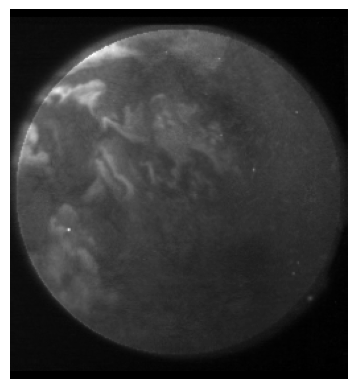

In [24]:
import matplotlib.pyplot as plt     #for displaying the image
import numpy as np                  #for converting the image from dataset to array
import h5py             


#opening the h5 file as an object named file 
with h5py.File(path_to_h5_file, "r") as file:

    #this would return a tuple containing the image size 
    FAI_Image_shape = file["FAI Image"].shape

    #creating an 2D array of 0s with the same size as the image shape 
    FAI_Image = np.zeros(FAI_Image_shape, dtype=np.float64)     

    #using prebuilt function of h5py to convert the image dataset into an array
    file["FAI Image"].read_direct(FAI_Image)                    

    #using matplotlib's imshow to show the image
    plt.imshow(FAI_Image, cmap="gray")                          
    #turning off the plot axis
    plt.axis("off")                                             
    plt.show()                                                  

&emsp; The goal of the above code is to open an h5 file and display the image stored within it. To accomplish the same, we first import the necessary modules: matplotlib to display the image on screen and numpy to convert the h5 dataset to an array. 

&emsp; We open the image using h5py and first get information about the shape of the "FAI Image" dataset and save it to the object FAI_Image_shape. FAI images could either be in shape of (280x256), (140x128) or (70x64) depending upon the "Camera Mode" binning number (4 = 256x280, 3 = 140x128, 2 = 70x64). Following that we create a numpy array of zeros of the same shape where all the zero values would be replaced with what's present in FAI Image dataset. Finally, using an already present function of h5py called *read_direct* we directly replace all the zero values of *FAI_Image* by what's present in the dataset. 

&emsp; To display *FAI_Image* on screen we utilize the functionality of matplotlib's *imshow* function and use the *show* function to display the image on screen. 

&emsp; Now, if instead of displaying the image you would like to save it in your current working directory or some other path, you can replace *plt* lines in the above code with the following line:

In [25]:
img_name = "FAI_Image.png"
plt.imsave(fname=img_name, arr=FAI_Image, cmap="gray", format="png")

<a id="applying-color-scaling-to-fai-images"></a>

### <ins>Applying Color Scaling to FAI Images</ins>

&emsp; FAI images may be scaled such that the top 0.1% of the pixel values are white, to ensure that a few "hot pixels" or upper outliers do not affect the entire color scheme of the image. Without this some images will appear completely dark and would become completely unusable even though they might contain useful information. 

&emsp; Therefore, to apply color scaling to the images, we would first need to find the pixel in the top 99.9% percentile, then convert any pixel which has a higher value than the top 99.9% value to that value. The following code provides a complete tutorial about applying color scaling to one FAI Image:

The top 99.9 percentile from the image is:  295843.742101153


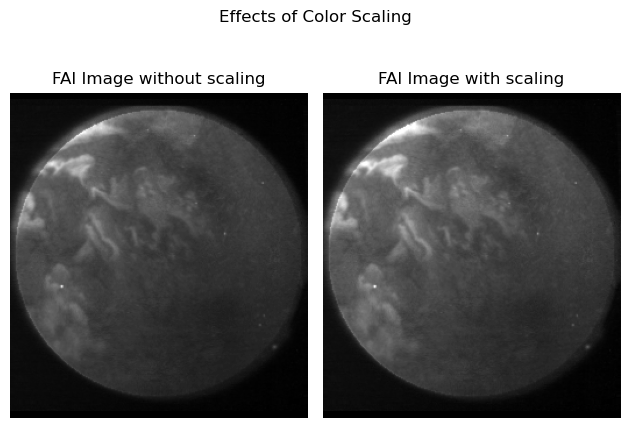

In [26]:
import h5py             #for getting FAI Image dataset
import numpy as np      #to convert image dataset to an array
import matplotlib.pyplot as plt     #to display/plot the images on screen


#path where the H5 file is stored
path_to_h5_file = "temp/FAI_lv1_NIR_20170201_081042_081042_6.0.0.h5"     

#opening the H5 file in a read format
with h5py.File(path_to_h5_file, "r") as file:

    #getting the shape of the FAI Image Dataset 
    FAI_Image_shape = file["FAI Image"].shape                                                               
    #creating an empty array of zeros with the same shape as the Image Dataset
    FAI_Image = np.zeros(FAI_Image_shape, dtype=np.float64)                                                 
    #replacing the zeros in the array with what's present in the dataset
    file["FAI Image"].read_direct(FAI_Image)                                                                

    #finding the value of the top 99.9 percentile pixel
    top_percentile = np.percentile(FAI_Image, 99.9)                                                         
    print("The top 99.9 percentile from the image is: ",top_percentile)

    #making a shallow copy of the original image array for comparison
    FAI_Image_adjusted = FAI_Image.copy()                                                                   
    #replacing all the values greater than top percentile with top percentile
    FAI_Image_adjusted[FAI_Image_adjusted>top_percentile]=top_percentile                                    

    #code for plotting the two images side-by-side

    #working on the first subplot
    plt.subplot(1,2,1)                                                                                      
    #displaying the image
    plt.imshow(FAI_Image, cmap="gray")                                                                      
    #title of the subplot
    plt.title("FAI Image without scaling")                                                                  
    #turning off the axis 
    plt.axis("off")                                                                                         
    
    #working on the second subplot
    plt.subplot(1,2,2)                                                                                      
    #displaying the image
    plt.imshow(FAI_Image_adjusted, cmap="gray")                                                             
    #title of the subplot
    plt.title("FAI Image with scaling")                                                                     
    #turning off the axis 
    plt.axis("off")                                                                                         

    #the figure title
    plt.suptitle("Effects of Color Scaling")                                                                
    #to make sure the titles don't overlap
    plt.tight_layout()                                                                                      
    #displaying the subplots on screen                   
    plt.show()                                                                                              

&emsp; In the above code, we first open and read the *FAI Image* as mentioned before, then we create a shadow copy of the FAI Image called *FAI_Image_adjusted* which would have the color scaling factor applied. We find the top 99.9 percentile value from the image array using *numpy*'s *percentile* function and then replace any values greater than that with the top percentile value. This makes sure that any value which is much greater than the top percentile does not end up outshining the entire image. 

&emsp; As you can see from the above plot, the image with the color scaling applied is a bit brighter compared to the original image, for your own projects you could convert the above code into a function and have some other value for top percentile.

<a id="converting-fai-images-into-an-basic-video"></a>

### <ins>Converting FAI Images into an basic video</ins>

To create a basic video from of all the images within the h5 files, we would first have to read the FAI image information from each h5 file and then use some module to convert those into a video.

The videos we create in this tutorial are created using *matplotlib*'s animation function but you could use any other python module that can deal with images and videos, such as *open-cv*.

The following tutorial will walk you through the process. We will plot the image on a figure along with its attribute information. 

1. First, importing all the necessary libraries:

In [27]:
import matplotlib.pyplot as plt     #plotting the images
import matplotlib.animation as anim #creating the videos 
import h5py                         #reading the FAI image and attributes
import numpy as np                  #storing FAI images
import os                           #finding the directories 
import glob                         #finding h5 files

2. Finding all the h5 files in a given camera mode

In [28]:
#path where the h5 files are stored
folder_name = "temp/"                            

#finding all the files which have an extension .h5 within the folder
path_to_h5_files = [x for x in glob.glob(folder_name+"/*.h5", recursive=False)]     

#empty list to store path to all h5 files taken in NIR
NIR_h5_files = []                                                                   
#empty list to store path to all h5 files taken in VIS
VIS_h5_files = []                                                                   

#this loop would check whether a h5 file was created with NIR or VIS
for x in path_to_h5_files:

    #condition is true if filename contains "NIR"
    if "NIR" in x:
        NIR_h5_files.append(x)

    #condition is true if filename contains "VIS"
    elif "VIS" in x:
        VIS_h5_files.append(x)

&emsp; So, the above code would require the name of the folder where all the h5 files are stored, then we store the path to each individual h5 file within an object called *path_to_h5_files*.

&emsp; As we remember that the FAI camera can take images from two CCDs- Near Infrared and Optical wavelengths. It is important to separate the path to h5 files into two different lists one which would store the path to images taken by the NIR camera and one which would store the images taken from VIS camera. We achieve this by looping over *path_to_h5_files* and checking whether the path contains NIR or VIS. You can potentially create more checks depending upon your needs.

3. Now, with the path to h5 files in our hands we can move further by first reading and storing each image into a numpy array and storing all the attribute information in a pandas dataframe. The following code shows how it done:

In [29]:
#the following condition will be true if there are NIR files present 
if len(NIR_h5_files)>0:

    #empty list to store all images as numpy arrays
    NIR_images = []                                     
    #empty list to store attribute information for each image as dict
    NIR_attrs = []                                      

    #this loop would go over all the h5 files in the folder 
    #and add the image along with its attributes to their respective lists
    for x in range(len(NIR_h5_files)):

        #opening each h5 file within the folder
        with h5py.File(NIR_h5_files[x]) as NIR_file:

            #checking the shape of the FAI Image Dataset
            NIR_image_shape = NIR_file["FAI Image"].shape                   
            #creating a numpy array which would hold the image data
            NIR_image = np.zeros(NIR_image_shape, dtype=np.float64)         
            #replacing the zeros in the array with what's present in the image data
            NIR_file["FAI Image"].read_direct(NIR_image)                    

            #applying color scaling to images

            #finding value of top 99.9 percentile pixel 
            top_percentile = np.percentile(NIR_image, 99.9)                 
            #replacing all values greater than top percentile with top percentile
            NIR_image[NIR_image>top_percentile] = top_percentile            

            #appending image data to its list
            NIR_images.append(NIR_image)                                    

            #creating a dictionary for attributes
            NIR_attr = {key:value for key, value in NIR_file.attrs.items()} 
            #appending dictionary to its respective list 
            NIR_attrs.append(NIR_attr)                                      


&emsp; In the above code we first check whether there were h5 files created using the NIR camera. If that condition is true, then we create two empty lists which would contain the data for the image data and its respective attributes. 

&emsp; Here, we are using the conditional *if* statement only for checking NIR files but the same process can be repeated for images from VIS camera. If you would like to make your code much more concise then you can easily convert the above block of code into a function as the process would be the same regardless of the camera mode.

4. With the image and attribute data in their lists, we proceed further to see what a single frame would look like. 

&emsp; The following code displays what one frame of the video would look like. 

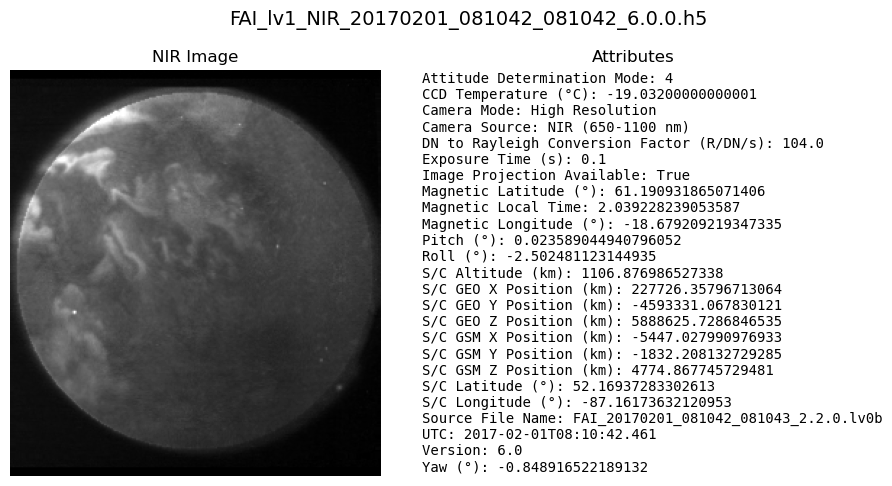

In [30]:
#creating an empty figure where image and attributes will be plotted
fig = plt.figure(figsize=(10, 5))                       
#gridspec helps in formatting the plot/figure to our needs 
gs = fig.add_gridspec(1, 2)                             

#subplot/axis which would contain the image
ax = fig.add_subplot(gs[0, 0])                          
#subplot/axis which would contain the attributes
ax2 = fig.add_subplot(gs[0, 1])                         

#title of image axis
ax.set_title("NIR Image", fontsize=12)                  
#title of attribute axis
ax2.set_title("Attributes",fontsize=12)                 

#to turn off the axis labels for image axis 
ax.axis("off")                                          
#to turn off the axis labels for attribute axis
ax2.axis("off")                                         

#data for first image from the h5 file 
img = NIR_images[0]                                     
#data for attributes of the first image
attr = NIR_attrs[0]                                     

#plotting image in the first subplot
ax_img = ax.imshow(img, cmap="gray", aspect="equal")    

#as the attributes are a dictionary, 
#we use the following line to convert them to a string
attribute_text = '\n'.join([f'{key}: {value}' for key, value in NIR_attrs[0].items()])

#with the attributes dictionary converted to string,
#we can plot it on the second subplot
ax2.text(0, 0.5, attribute_text, ha='left', 
         va='center', fontsize=10, fontfamily="monospace")


#title of the figure
fig.suptitle(os.path.basename(NIR_h5_files[0]), fontsize=14)    
#to automatically adjust subplots parameters                         
fig.tight_layout()                                      
#displaying the figure on screen
plt.show()                                              

&emsp; This is a basic example of how you can manipulate the subplots to display different information. Here, we displayed the image along with its attributes using *matplotlib*. For your own work you might require different information to be displayed, hopefully the above code gives you an idea of how to manipulate subplots and get you where you want.  

5. Now that we are satisfied with the first frame of the video, we can proceed to create the video which would help in the visualization process.

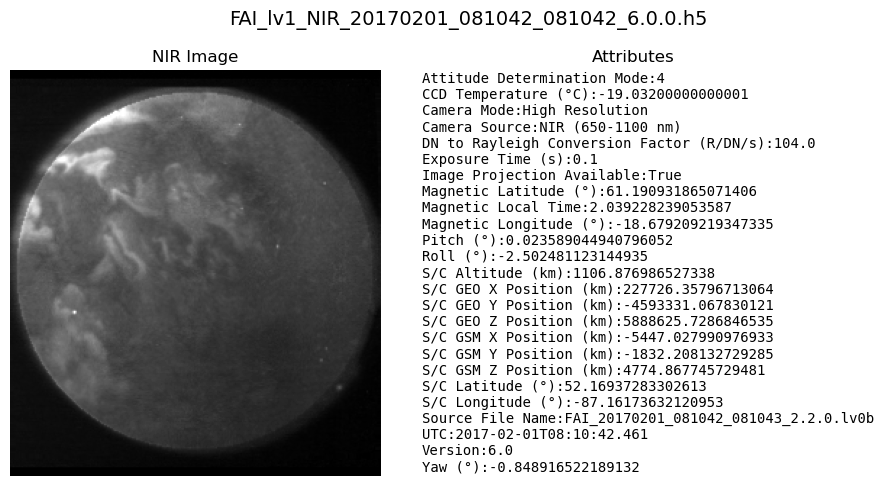

In [31]:
#creating the range of frames i.e 0 to number of images
frame = range(len(NIR_images))                          

#creating empty figure where image and attributes will be plotted
fig = plt.figure(figsize=(10, 5))                       
#gridspec helps in formatting the the figure to our needs 
gs = fig.add_gridspec(1, 2)                             

#the subplot/axis which would contain the image
ax = fig.add_subplot(gs[0, 0])                          
#the subplot/axis which would contain the attributes
ax2 = fig.add_subplot(gs[0, 1])                         

#title of the image axis
ax.set_title("NIR Image", fontsize=12)                  
#title of the attribute axis
ax2.set_title("Attributes",fontsize=12)                 

#this would turn off the axis labels for the image axis 
ax.axis("off")                                          
#this would turn off the axis labels for attribute axis
ax2.axis("off")                                         

#data for the first image from the h5 file 
img = NIR_images[0]                                     
#data for the attributes of the first image
attr = NIR_attrs[0]                                     

#plotting the image in the first subplot
ax_img = ax.imshow(img, cmap="gray", aspect="equal")    

#the attributes are a dictionary, 
#so use the following line to convert them to a string
attribute_text = '\n'.join([f'{key}: {value}' for key, value in NIR_attrs[0].items()])

#plotting attributes on the second subplot
ax2_attr = ax2.text(0, 0.5, attribute_text, ha='left',
                     va='center', fontsize=10, fontfamily="monospace")

#title of the figure
fig.suptitle(os.path.basename(NIR_h5_files[0]), fontsize=14)    
#to automatically adjust subplots parameters                         
fig.tight_layout()                                      


#this is the function which would return the updated image and attribute information
def func(frame, ax, ax2, NIR_images, NIR_attrs):
    #opening the next image 
    img = NIR_images[frame]                             
    #plotting the image on the subplot
    ax_img.set_data(img)                                
    #autoscale the axis to view the data            
    ax_img.autoscale()                                  

    #updating the attribute_text string to contain information about the next image 
    attr_text = '\n'.join([f'{key}:{value}' for key, value in NIR_attrs[frame].items()])
    #displaying the attributes on the plot
    ax2_attr.set_text(attr_text)                   

    #updating title for each frame
    fig.suptitle(os.path.basename(NIR_h5_files[frame]), fontsize=14)

    #returning the updated axes to the function call
    return ax, ax2                                      

#the following line would plot images and attribute information using func 
ani = anim.FuncAnimation(fig, func, frames=frame, 
                         fargs=(ax, ax2, NIR_images, NIR_attrs))

#defining the properties of the video
writervideo = anim.FFMpegWriter(fps=10)

#after all the frames are created and rendered,
#providing information about how the video is saved
ani.save("FAI_video.mp4", writer=writervideo, dpi=200)

&emsp; In the above code we first set the information about how the first frame of the video would look like, following that we create a function by the name *func* which would consistently update the figure and provide us with the next image and its attributes. 

&emsp; Finally, we use the animation functionality of *matplotlib* to create the video, and save it at a frame rate of 10 images per second but that can be changed depending on your needs. You can read more about how the animation function works __[here](https://matplotlib.org/stable/api/animation_api.html)__.

&emsp; Please note that you might run into errors if *ffmepg* is not correctly set up on your local machine. For more information about how to setup *ffmpeg*, please go __[here](https://ffmpeg.org/about.html)__. Also, the time required to save and render the entire video would depend upon the hardware of your local machine, so, don't worry if the code takes a bit of time to run.

<a id="projecting-the-images-on-a-map"></a>

### <ins>Projecting the images on a map</ins>

Now, that we know how to display the FAI images and convert the files into a video, we can move forward with projecting the image onto a map using it's attributes. We would be using *cartopy* to accomplish this and you could go through the documentation __[here](https://scitools.org.uk/cartopy/docs/latest/)__.

We already have the geophysical information saved in *NIR_attrs* and we can use the same for projecting the image on the map using some python gymnastics. The geophysical information from the spacecraft is in latitude and longitudes, which we will use here. 

Please note that the following code would work best for the times when the spacecraft is looking straight down (in the so=called 'NADIR' orientation). One simple check for this would be to make sure that the yaw, pitch and roll values are close to 0. If they deviate more than some threshold then the spacecraft is in a tilted orientation and the corresponding images would be from a different region than the S/C's own position. Also, the physical region covered by the image would depend upon the altitude of the spacecraft which is a part of h5 attributes as well.

The following code is a walkthrough of projecting FAI images and their attributes on a map. 

**Note**: The map projections will work best when working with images taken from the NADIR position

1. Importing all the necessary libraries

In [32]:
import matplotlib.pyplot as plt                         #for creating frames
from cartopy import crs as ccrs, feature as cfeature    #working with maps 
import cartopy.mpl.gridliner as cgridliner              #display latitudes and longitudes
import numpy as np                                      #store dataset values 
import h5py                                             #for reading h5 files
from scipy import ndimage                               #for euclidean distance
import warnings                                         #check for attitude quality
import matplotlib.animation as anim                     #create and save video file
import glob                                             #to check for h5 files

2. Initializing the code with the folder we wish to work with and checking for NIR or VIS files.

In [33]:
#folder storing all h5 files from one pass
folder_name = "temp/"   
#finding all h5 files 
path_to_h5_files = [x for x in glob.glob(folder_name + "/*.h5", recursive=False)]   

#empty list to store NIR h5 files                                   
NIR_h5_files = []                                           
#empty list to store VIS h5 files
VIS_h5_files = []                                           

#loop which goes over all h5 files and appends NIR and VIS files to their lists
for x in path_to_h5_files:
    
    #condition to check for NIR files
    if "NIR" in x:
        NIR_h5_files.append(x)

    #condition to check for VIS files
    elif "VIS" in x:
        VIS_h5_files.append(x)

3. For this demonstration we are going to be working with only NIR files, but you can easily do the same for VIS files. 

&emsp; The following block would read h5 files and make sure we are working with *Attitude Determination Mode* as 4.

In [34]:
#best attitude determination modes
usable_quality = ["4"]                                                  
#not recommended to be used for map projection
unusable_quality = ["0", "1", "2", "3"]                                 

#condition would be true if folder contains NIR h5 files
if len(NIR_h5_files) > 0:

    #empty list to contain NIR images
    NIR_images = []              

    #empty list to contain pixel latitudes
    NIR_pixel_lats = []       

    #empty list to conatin pixel longitudes
    NIR_pixel_longs = []     

    #empty list to contain image attributes
    NIR_attrs = []                                                      

    #looping over all NIR h5 files and 
    #appending required information to their lists
    for x in range(len(NIR_h5_files)):

        #opening h5 file as NIR_file
        with h5py.File(NIR_h5_files[x]) as NIR_file:
            #making a dictionary of attributes
            attributes = {key: value for key, value in NIR_file.attrs.items()}  

            #checking if Attitude Determination Mode belongs to unusable_quality list
            if attributes["Attitude Determination Mode"] in unusable_quality:
                
                #print warning if attitude determination mode
                #does not belong to usable_quality list
                warnings.warn(
                    """Attitude Determination Mode: {}, not recommended to be used"""
                    .format(attributes["Attitude Determination Mode"]),
                    stacklevel=2)                                              
            

            #if the attitude determination mode belongs to usable_quality list 
            else:

                #converting FAI image to numpy array 

                #the shape of FAI image from FAI Image dataset
                NIR_image_shape = NIR_file["FAI Image"].shape           
                #numpy array of 0s with the same shape as FAI Image dataset
                NIR_image = np.zeros(NIR_image_shape, dtype=np.float64) 
                #replacing 0s from the array to store FAI Image data
                NIR_file["FAI Image"].read_direct(NIR_image)            

                #applying color scaling to image

                #finding value of pixel belonging to 99.9 percentile         
                top_percentile = np.percentile(NIR_image, 99.9)         
                #replacing all values greater than top percentile with top percentile
                NIR_image[NIR_image > top_percentile] = top_percentile  

                #appending image array to list
                NIR_images.append(NIR_image)                            

                #converting Pixel Latitudes to numpy array 
                #shape of Pixel Latitude dataset from h5 file
                Pixel_lats_shape = NIR_file["Pixel Latitudes"].shape    
                #numpy array of 0s with the same shape as Pixel Latitudes
                Pixel_lats = np.zeros(Pixel_lats_shape, dtype=np.float32)   
                #replacing 0s in the array to store Pixel Latitudes information
                NIR_file["Pixel Latitudes"].read_direct(Pixel_lats)     

                #appending latitude array to list
                NIR_pixel_lats.append(Pixel_lats)                       

                #converting Pixel Longitudes to numpy array
                #shape of Pixel Longitude dataset from h5 file
                Pixel_longs_shape = NIR_file["Pixel Longitudes"].shape  
                #numpy array of 0s with the same shape as Pixel Longitudes
                Pixel_longs = np.zeros(Pixel_longs_shape, dtype=np.float32) 
                #replacing 0s in the array to store Pixel Longitudes information
                NIR_file["Pixel Longitudes"].read_direct(Pixel_longs)   

                #appending longitude array to list
                NIR_pixel_longs.append(Pixel_longs)                     

                #converting attribute information to dictionary
                attributes = {key:value for key,value in NIR_file.attrs.items()}    
                #appending attributes to list 
                NIR_attrs.append(attributes)                            

4. Now, we have all the information required to create a basic map projection with Stereographic projection. We wil be using the functionality of matplotlib and cartopy to accomplish the same

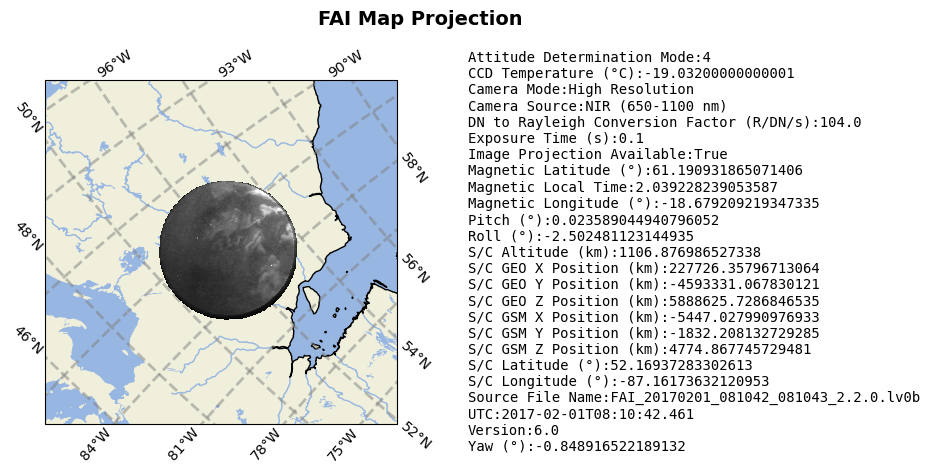

In [36]:
#number of frames/images to be created                    
frame = range(len(NIR_images))                                          

#function to update each frame for the video
def update_frame(frame):
    
    #uncomment the following line to
    #print the frame number 
    # print("Frame:",frame)                                               
    #to clear the figure 
    fig.clear()                                                         
    #projection to be used on axis 1  
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.Stereographic())     
    #axis 2 for displaying attribute information
    ax2 = fig.add_subplot(1, 2, 2)                                      

    #finding value of minimum latitude which is not NaN
    min_Lat = np.nanmin(NIR_pixel_lats[frame])                          
    #finding value of maximum latitude which is not NaN
    max_Lat = np.nanmax(NIR_pixel_lats[frame])                          
    #finding value of minimum longitude which is not NaN
    min_Long = np.nanmin(NIR_pixel_longs[frame])                        
    #finding value of maximum longitude which is not NaN
    max_Long = np.nanmax(NIR_pixel_longs[frame])                        

    #setting the extent of map projection 
    ax1.set_extent([min_Long - 2, max_Long + 2, min_Lat - 2, max_Lat + 2], 
                   crs=ccrs.PlateCarree())
    #adding land as feature on map
    ax1.add_feature(cfeature.LAND)                                      
    #adding ocean as feature on map
    ax1.add_feature(cfeature.OCEAN)                                     
    #adding lakes as feature on map
    ax1.add_feature(cfeature.LAKES)                                     
    #adding rivers as feature on map
    ax1.add_feature(cfeature.RIVERS)                                    
    #adding coastlines to map
    ax1.coastlines()                                                    

    #adding latitude and longitude gridlines on map projection 
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2,
                       color="gray", alpha=0.5, linestyle="--", x_inline=False,
                       y_inline=False, dms=True)
    gl.xlines = True                                                    
    gl.ylines = True
    gl.xformatter = cgridliner.LONGITUDE_FORMATTER
    gl.yformatter = cgridliner.LATITUDE_FORMATTER

    #finding exact Euclidean distance using Pixel Latitude information
    ind = ndimage.distance_transform_edt(np.isnan(NIR_pixel_lats[frame]), 
                                         return_distances=False, 
                                         return_indices=True)
    pixelLat = NIR_pixel_lats[frame][tuple(ind)]
    pixelLon = NIR_pixel_longs[frame][tuple(ind)]

    #displaying image on axis 1 using pixelLon, pixelLong and image information
    im = ax1.pcolormesh(pixelLon, pixelLat, NIR_images[frame],
                        transform=ccrs.PlateCarree(), cmap="gray", zorder=3)
    
    #converting attribute dictionary to string 
    attr_text = "\n".join([f'{key}:{value}' for key, value in NIR_attrs[frame].items()])
    #displaying attribute dictionary on subplot 2
    ax2.text(0, 0.5, attr_text, ha='left', 
             va='center', fontsize=10, fontfamily="monospace")
    #turning off axis for subplot 2
    ax2.axis('off')                                                     

    #title of frame 
    fig.suptitle('FAI Map Projection', fontsize=14, fontweight='bold')  


#setting up a matplotlib figure object
fig = plt.figure(figsize=(10, 5))                                       

#updating each frame 
ani = anim.FuncAnimation(fig, update_frame, frames=frame)               
#creating a video file using 10 frames per second 
writervideo = anim.FFMpegWriter(fps=10)                                 
#saving the created video with dpi = 100
ani.save("FAI_map_projection.mp4", writer=writervideo, dpi=200)   

&emsp; In the above code we first calculate the number of frames that will go into creating the video. We then proceed to create a function called *update_frame* which will update the figure with the current information from FAI image, pixel latitude, pixel longitude and attributes dataset to produce the video. The code uses information and snippets used in previous sections to build the projection and can easily be modified to suit your needs. 

**Note**: The time required to save and render the entire video would depend upon the hardware of your local machine, so, don't worry if the code takes a bit of time to run. On our system is about 3 minutes 1 seconds to create the file with 200 dpi, you can potentially reduce time with reducing dpi to 100 or some other low value. 